In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
import pandas as pd
import numpy as np
import json

import sys
import os

sys.path.append(os.path.abspath('../'))
from tool import *

data_root = '../../MyData/'

# Load data (With GICS_Sector)

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings', 'GICS_Sector']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings  \
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...   
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....   
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...   
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...   
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...   

   GICS_Sector  
0         20.0  
1         55.0  
2         15.0  
3         30.0  
4         35.0  
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LO

,cik,tic,Year,item1_embeddings,GICS_Sector,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...",20.0,"[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....",55.0,"[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...",15.0,"[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...",30.0,"[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...",35.0,"[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
GICS_Sector                   0.006683
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




In [4]:
only_item1 = total_embedding[total_embedding[['GICS_Sector']].isna().all(axis=1)]
len(only_item1)

8

# Load ae

In [5]:
from model.obtain_model import load_ae
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_ae = load_ae("../model/saved_models/basic_ae.pth", device)

In [6]:
# # Assuming x is a batch of input data (1D, not images)
# x = next(iter(test_loader))  # Get a batch of data
# x = x[0][8:16]

# # Encode the input
# trained_ae.eval()
# with torch.no_grad():
#     x = x.unsqueeze(1)
#     generated_samples = trained_ae(x.to(device))
    
#     # Move to CPU and convert to numpy if necessary
#     x = x.cpu()
#     x = x.squeeze(1)
#     print(x.shape)
#     generated_samples = generated_samples.cpu()
#     generated_samples = generated_samples.squeeze(1)
#     print(generated_samples.shape)
    
#     # Plot the original and generated samples in separate subplots
#     fig, axes = plt.subplots(8, 1, figsize=(12, 24))  # 8 rows, 1 column
    
#     for i in range(8):
#         axes[i].plot(x[i][900:1100], label="Original", linestyle='-', color='b', alpha=0.7)
#         axes[i].plot(generated_samples[i][900:1100], label="Generated", linestyle='--', color='r', alpha=0.7)
#         axes[i].set_title(f"Sample {i+1}")
#         axes[i].set_xlabel("Data Dimension")
#         axes[i].set_ylabel("Value")
#         axes[i].legend()
    
#     plt.tight_layout()
#     plt.show()


# Train classifier

### Prepare training data and label

In [7]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'SP_SHORT_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year', 'GICS_Sector']

# Drop rows that don't have GICS label
total_embedding = total_embedding.dropna(subset=['GICS_Sector'])
exp_df = convert_to_array(total_embedding, info_list, target_list, 1536, False)
# print(type(exp_df))
# print(exp_df.shape)

# Dictionary to store the stacked embeddings
embedding_arrays = {}
label_arrays = {}

# Loop through the columns and apply np.vstack
for col in target_list:
    embedding_arrays[col] = np.vstack(exp_df[col].values)
    nan_mask = ~np.any(np.isnan(embedding_arrays[col]), axis=1)

    embedding_arrays[col] = embedding_arrays[col][nan_mask]
    label_arrays[col] = exp_df['GICS_Sector'][nan_mask]

In [8]:
X = np.vstack([embedding_arrays['item1_embeddings'],
               embedding_arrays['SP_LONG_DESC_embeddings'],
               embedding_arrays['SP_SHORT_DESC_embeddings'],
               embedding_arrays['ORBIS_PROD_SERV_embeddings'],
               embedding_arrays['ORBIS_OVERVIEW_embeddings']])
print(type(X))
print(X.shape)

label_df = pd.concat([label_arrays['item1_embeddings'],
                    label_arrays['SP_LONG_DESC_embeddings'],
                    label_arrays['SP_SHORT_DESC_embeddings'],
                    label_arrays['ORBIS_PROD_SERV_embeddings'],
                    label_arrays['ORBIS_OVERVIEW_embeddings']], ignore_index=True)
Y = pd.get_dummies(label_df)
print(type(Y))
print(Y.shape)

<class 'numpy.ndarray'>
(5362, 1536)
<class 'pandas.core.frame.DataFrame'>
(5362, 11)


In [9]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # Input features
y_tensor = torch.tensor(Y.values, dtype=torch.float32)  # One-hot encoded labels (convert from DataFrame)

# Custom Dataset class with labels
class AE_Dataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return both input data (features) and corresponding labels
        return self.features[idx], self.labels[idx]

# Create the full dataset with both features and labels
dataset = AE_Dataset(X_tensor, y_tensor)

# Split dataset into train and test (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the shape of a batch (should print both features and labels)
for batch in train_loader:
    features, labels = batch
    print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")  # (64, 1536) for features, (64, 11) for labels
    break  # Just print the first batch



Features shape: torch.Size([64, 1536]), Labels shape: torch.Size([64, 11])


### Training Loop

In [10]:
from model.obtain_model import init_clasf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters
input_dim = 256
hidden_dim = 128
num_class = 11
drop_rate = 0.1

clasf = init_clasf(device, input_dim, hidden_dim, num_class, drop_rate)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(clasf.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    clasf.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Pre-process
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = trained_ae.encoder_net(inputs)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = clasf(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize the model
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest logit)
        total += labels.size(0)

        _, classes = torch.max(labels, 1)
        correct += (predicted == classes).sum().item()
    
    # Print training statistics for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/30], Loss: 1.0298, Accuracy: 71.51%
Epoch [2/30], Loss: 0.4005, Accuracy: 88.69%
Epoch [3/30], Loss: 0.3021, Accuracy: 91.40%
Epoch [4/30], Loss: 0.2685, Accuracy: 92.52%
Epoch [5/30], Loss: 0.2599, Accuracy: 92.38%
Epoch [6/30], Loss: 0.1794, Accuracy: 95.43%
Epoch [7/30], Loss: 0.1530, Accuracy: 95.99%
Epoch [8/30], Loss: 0.1270, Accuracy: 97.20%
Epoch [9/30], Loss: 0.1185, Accuracy: 96.83%
Epoch [10/30], Loss: 0.1071, Accuracy: 97.06%
Epoch [11/30], Loss: 0.0965, Accuracy: 97.53%
Epoch [12/30], Loss: 0.1081, Accuracy: 96.99%
Epoch [13/30], Loss: 0.0898, Accuracy: 97.32%
Epoch [14/30], Loss: 0.0742, Accuracy: 98.11%
Epoch [15/30], Loss: 0.0611, Accuracy: 98.41%
Epoch [16/30], Loss: 0.0596, Accuracy: 98.23%
Epoch [17/30], Loss: 0.0564, Accuracy: 98.37%
Epoch [18/30], Loss: 0.0522, Accuracy: 98.37%
Epoch [19/30], Loss: 0.0468, Accuracy: 98.60%
Epoch [20/30], Loss: 0.0449, Accuracy: 98.72%
Epoch [21/30], Loss: 0.0490, Accuracy: 98.60%
Epoch [22/30], Loss: 0.0526, Accuracy: 98.3

In [11]:
# Evaluation loop (on the test dataset)
clasf.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        # Pre-process
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = trained_ae.encoder_net(inputs)

        # Projection and predict
        outputs, _ = clasf(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        _, classes = torch.max(labels, 1)
        correct += (predicted == classes).sum().item()

# Print test accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.17%


In [ ]:
# torch.save(clasf.state_dict(), "../model/saved_models/clasf.pth")

# Test Classifier

### Load classifier

In [7]:
from model.obtain_model import load_clasf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_clasf = load_clasf("../model/saved_models/clasf.pth", device)

### Prepare data

In [21]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year', 'GICS_Sector']

# total_embedding = total_embedding.dropna(subset=['GICS_Sector'])
exp_df = convert_to_array(total_embedding, info_list, target_list, 1536, False)
print(type(exp_df))
print(exp_df.shape)


# Dictionary to store the stacked embeddings as PyTorch tensors
embedding_tensors = {}

# Loop through the columns and convert to PyTorch tensor
for col in target_list:
    numpy_array = np.vstack(exp_df[col].values)  # Stack the column values
    embedding_tensors[col] = torch.tensor(numpy_array, dtype=torch.float32)  # Convert to tensor

d:\NGNE\clustering_project\CP3106\tool.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[target] = data_df[target].apply(


<class 'pandas.core.frame.DataFrame'>
(1197, 7)


In [51]:
'''
convert original embeddings to new latent space with trained_ae and trained_clasf
'''
def safe_inference(model, input_tensor):
    '''
    Passes the input tensor through the network,
    skipping rows containing only NaNs while preserving their original positions in the output.
    '''
    # Create a mask to identify NaN rows
    nan_mask = torch.isnan(input_tensor).all(dim=1)  # True for rows that are fully NaN
    
    # Extract valid (non-NaN) rows
    valid_rows = input_tensor[~nan_mask]  # Select rows where nan_mask is False
    
    with torch.no_grad():
        valid_output = model(valid_rows)

    if isinstance(valid_output, tuple):
        _, valid_output = valid_output
    
    # Create an output tensor filled with NaNs
    output = torch.full((input_tensor.shape[0], valid_output.shape[1]), float('nan'), device=input_tensor.device)
    
    # Insert computed values into the non-NaN positions
    output[~nan_mask] = valid_output
    
    return output

latent_tensors = {}
for col in target_list:
    after_encoder = safe_inference(trained_ae.encoder_net, embedding_tensors[col].to(device))
    latent_tensors[col] = safe_inference(trained_clasf, after_encoder)

In [52]:
'''
Calculate the average of 
'''
def average_tensors(tensor_dict):
    """
    Computes the element-wise average of 2D tensors in a dictionary, 
    while handling NaN values properly.
    
    :param tensor_dict: Dictionary where values are 2D tensors of the same shape
    :return: A 2D tensor with the averaged values
    """
    tensor_list = list(tensor_dict.values())  # Extract tensors
    
    # Stack tensors along a new dimension (shape: [num_tensors, rows, cols])
    stacked_tensors = torch.stack(tensor_list, dim=0)

    # Create a mask for valid (non-NaN) values
    valid_mask = ~torch.isnan(stacked_tensors)

    # Replace NaNs with 0 for summation
    stacked_tensors = torch.nan_to_num(stacked_tensors, nan=0.0)

    # Sum across all tensors (axis=0)
    summed_tensors = torch.sum(stacked_tensors, dim=0)

    # Count valid (non-NaN) values at each position
    valid_counts = valid_mask.sum(dim=0)

    # Avoid division by zero and compute the average
    average_tensor = summed_tensors / torch.clamp(valid_counts, min=1)

    return average_tensor

average_latent = average_tensors(latent_tensors).cpu()

In [53]:
average_latent

tensor([[-0.4005,  0.4119,  0.0363,  ...,  0.5296, -0.0214,  0.0187],
        [ 0.0550, -0.2603, -0.1582,  ..., -0.3064,  0.2351, -0.2542],
        [ 0.9008, -0.1728, -0.1548,  ..., -0.5760, -0.5299,  0.2897],
        ...,
        [ 0.1841, -0.3887, -0.4437,  ...,  0.0854, -0.1317, -0.1603],
        [ 0.2235, -0.0065, -0.4112,  ..., -0.0309,  0.6061, -0.2538],
        [-0.0974,  1.0479,  0.1745,  ...,  0.5266,  0.2795, -0.1716]])

In [54]:
exp_df = exp_df[['cik', 'tic', 'Year']]
exp_df['cluster_10'] = cluster(average_latent, 10)
exp_df['cluster_100'] = cluster(average_latent, 100)
exp_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.11182582667198596
Normalized Within-Cluster Sum of Squares (WCSS): 0.05706259999159683


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,5,45
1,352541,LNT,2021,4,11
2,1704715,AMR,2021,6,9
3,1575515,SFM,2021,7,72
4,1125376,ENSG,2021,3,40
...,...,...,...,...,...
1192,1021860,NOV,2021,4,33
1193,1744489,DIS,2021,9,86
1194,1102112,PACW,2021,2,22
1195,28823,DBD,2021,8,43


In [55]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp_returns = pd.merge(exp_df, returns_long, on='tic', how='inner')

exp_intra_corrs_10 = intra_industry_correlations(exp_returns, "cluster_10")
exp_avg_intra_corr_10 = np.nanmean(list(exp_intra_corrs_10.values()))
print(exp_avg_intra_corr_10)

exp_intra_corrs_100 = intra_industry_correlations(exp_returns, "cluster_100")
exp_avg_intra_corr_100 = np.nanmean(list(exp_intra_corrs_100.values()))
print(exp_avg_intra_corr_100)

print(len(exp_returns['cik'].unique()))

0.3654350119453379
0.4390190142157174
1064


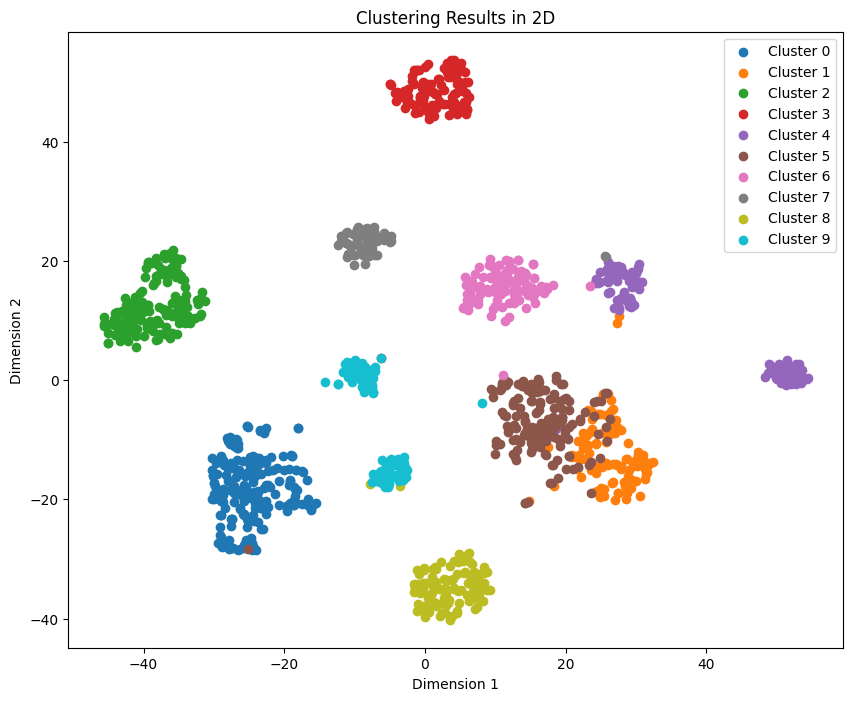

In [56]:
show_cluster_graph(average_latent, exp_df['cluster_10'])

In [58]:
exp_df.to_csv("../clustering_res/6_clasf.csv", index=False)